In [1]:
import sys
import os
import tensorflow as tf
import numpy as np
sys.path.append(".")
sys.path.append("./utils")
from custom_lbfgs import *
from SSAutil import *
from neuralnetwork import NeuralNetwork, MinmaxScaleLayer, UpScaleLayer
from logger import Logger
from plotting import *
import matplotlib.pyplot as plt

In [2]:
# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

# Hyper parameters {{{
hp = {}
# Data size on the solution u
hp["N_u"] = 3000
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = 1000
# DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
hp["layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2]
#hp["C_layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 1000
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 1000
hp["nt_lr"] = 0.8
hp["nt_ncorr"] = 50
hp["log_frequency"] = 100
hp["use_tfp"] = False
# Record the history
hp["save_history"] = True
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
#path = os.path.join(appDataPath, "SSA2D_circleF.mat")
path = os.path.join(appDataPath, "SSA2D_segCF.mat")
modelPath = "./Models/SheetCircleF"
reloadModel = False # reload from previous training
#}}}

In [3]:
class SSAInformedNN(NeuralNetwork): #{{{
    def __init__(self, hp, logger, X_f, 
            X_bc, u_bc, X_cf, n_cf, 
            xub, xlb, uub, ulb, 
            modelPath, reloadModel,
            eta, n=3.0, geoDataNN=None, FrictionCNN=None):
        super().__init__(hp, logger, xub, xlb, uub[0:2], ulb[0:2], modelPath, reloadModel=reloadModel)

        # friction C model
        if FrictionCNN:
            self.C_model = tf.keras.models.load_model(FrictionCNN)
        else:
            # set C model
            C_layers = hp["C_layers"]
            self.C_model = tf.keras.Sequential()
            # input layer
            self.C_model.add(tf.keras.layers.InputLayer(input_shape=(C_layers[0],)))
            # normalization layer
            self.C_model.add(MinmaxScaleLayer(xlb, xub))
            # NN layers
            for width in C_layers[1:-1]:
                self.C_model.add(tf.keras.layers.Dense(
                    width, activation=tf.nn.tanh,
                    kernel_initializer="glorot_normal"))
            # output layer
            self.C_model.add(tf.keras.layers.Dense(
                    C_layers[-1], activation=None,
                    kernel_initializer="glorot_normal"))
    
            # denormalization layer
            self.C_model.add(UpScaleLayer(ulb[2], uub[2]))
    
            # Computing the sizes of weights/biases for future decomposition
            for i, width in enumerate(C_layers):
                if i > 0:
                    self.sizes_w.append(int(width * C_layers[i-1]))
                    self.sizes_b.append(int(width))
                
            # set up trainable layers and variables
            self.trainableLayers = (self.model.layers[1:-1]) + (self.C_model.layer[1:-1])
            self.trainableVariables = self.model.trainable_variables + self.C_model.trainable_variables

        # scaling factors
        self.ub = xub
        self.lb = xlb

        # Dirichlet B.C.
        self.X_bc = self.tensor(X_bc)
        self.u_bc = u_bc

        # Calving front
        self.X_cf = self.tensor(X_cf)
        self.n_cf = n_cf

        # viscosity
        self.eta = eta
        self.n = n

        # some constants
        self.rhoi = 917  # kg/m^3
        self.rhow = 1023 # kg/m^3
        self.g = 9.81    # m/s^2
        self.hmin = 300
        self.hmax = 1000
        self.yts = 3600.0*24*365

        # Separating the collocation coordinates
        self.x_f = self.tensor(X_f[:, 0:1])
        self.y_f = self.tensor(X_f[:, 1:2])

        # use H and bed interpolator
        if geoDataNN: 
            self.H_bed_model = tf.keras.models.load_model(geoDataNN)

    def geometry_NN(self, X):
        Hb = self.H_bed_model(X)
        H = Hb[:, 0:1]
        b = Hb[:, 1:2]
        return H, b

    # get the velocity and derivative information
    @tf.function
    def uvx_model(self, X):
        x = X[:, 0:1]
        y = X[:, 1:2]
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(y)
            Xtemp = tf.concat([x, y], axis=1)

            UV = self.model(Xtemp)
            u = UV[:, 0:1]
            v = UV[:, 1:2]

        u_x = tape.gradient(u, x)
        v_x = tape.gradient(v, x)
        u_y = tape.gradient(u, y)
        v_y = tape.gradient(v, y)
        del tape

        return u, v, u_x, v_x, u_y, v_y

    # Calving front condition
    @tf.function
    def cf_model (self, X, n):
        x = X[:, 0:1]
        y = X[:, 1:2]
        nx = n[:, 0:1]
        ny = n[:, 1:2]

        # viscosity
        eta = self.eta
        n = self.n

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(y)
            Xtemp = tf.concat([x, y], axis=1)

            # geometry
            H, bed = self.geometry_NN(Xtemp)
            h = H + bed

            # velocity component
            u, v, u_x, v_x, u_y, v_y = self.uvx_model(Xtemp)

            # viscosity
            epsilon = 0.5*eta *(u_x**2 + v_y**2 + 0.25*(u_y+v_x)**2 + u_x*v_y+1.0e-30)**(0.5*(1.0-n)/n)
            # stress tensor
            etaH = epsilon * H
            B11 = etaH*(4*u_x + 2*v_y)
            B22 = etaH*(4*v_y + 2*u_x)
            B12 = etaH*(  u_y +   v_x)
        del tape

        # Calving front condition
        fc1 = B11 *nx + B12*ny - 0.5*self.g*(self.rhoi*H*H - self.rhow*bed*bed)*nx
        fc2 = B12 *nx + B22*ny - 0.5*self.g*(self.rhoi*H*H - self.rhow*bed*bed)*ny

        return fc1, fc2

    # The actual PINN
    @tf.function
    def f_model(self):
        # viscosity
        eta = self.eta
        n = self.n

        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and y
            tape.watch(self.x_f)
            tape.watch(self.y_f)
            # Packing together the inputs
            X_f = tf.concat([self.x_f, self.y_f], axis=1)

            # get ice thickness and bed
            #H, bed, h_x, h_y = self.geometry_NN(X_f)
            H, bed = self.geometry_NN(X_f)
            h = H + bed

            # Getting the prediction
            u, v, u_x, v_x, u_y, v_y = self.uvx_model(X_f)

            epsilon = 0.5*eta *(u_x**2 + v_y**2 + 0.25*(u_y+v_x)**2 + u_x*v_y+1.0e-30)**(0.5*(1.0-n)/n)
            # stress tensor
            etaH = epsilon * H
            B11 = etaH*(4*u_x + 2*v_y)
            B22 = etaH*(4*v_y + 2*u_x)
            B12 = etaH*(  u_y +   v_x)

            # friction
            C = self.C_model(X_f)

        # Getting the other derivatives
        sigma11 = tape.gradient(B11, self.x_f)
        sigma12 = tape.gradient(B12, self.y_f)

        sigma21 = tape.gradient(B12, self.x_f)
        sigma22 = tape.gradient(B22, self.y_f)
                
        # surface gradient
        h_x = tape.gradient(h, self.x_f)
        h_y = tape.gradient(h, self.y_f)

        # Letting the tape go
        del tape
        u_norm = (u**2+v**2)**0.5
        alpha = C**2 * (u_norm)**(1.0/self.n)

        f1 = sigma11 + sigma12 - alpha*u/(u_norm+1e-30) - self.rhoi*self.g*H*h_x
        f2 = sigma21 + sigma22 - alpha*v/(u_norm+1e-30) - self.rhoi*self.g*H*h_y

        return f1, f2

    @tf.function
    def loss(self, uv, uv_pred):
        u0 = uv[:, 0:1]
        v0 = uv[:, 1:2]
        u0_pred = uv_pred[:, 0:1]
        v0_pred = uv_pred[:, 1:2]
        
        # f_model on the collocation points 
        f1_pred, f2_pred = self.f_model()

        # Calving on X_cf
        fc1_pred, fc2_pred = self.cf_model(self.X_cf, self.n_cf)

        # B.C.
        # Dirichlet on X_bc
#        u_bc = self.u_bc[:,0:1]
#        v_bc = self.u_bc[:,1:2]
#        #C_bc = self.u_bc[:,2:3]
#        #C_bc_pred = self.C_model(self.X_bc)
#        u_bc_pred, v_bc_pred, u_x_bc_pred, v_x_bc_pred, u_y_bc_pred, v_y_bc_pred = self.uvx_model(self.X_bc)
#        mse_uv_bc = 1e-6*(self.yts**2) * tf.reduce_mean(tf.square(u_bc - u_bc_pred)) + \
#                    1e-6*(self.yts**2) * tf.reduce_mean(tf.square(v_bc - v_bc_pred))
        #mse_C_bc = tf.reduce_mean(tf.square(C_bc - C_bc_pred))

        mse_u = 1e-2*(self.yts**2) * tf.reduce_mean(tf.square(u0 - u0_pred))
        mse_v = 1e-2*(self.yts**2) * tf.reduce_mean(tf.square(v0 - v0_pred))
        mse_f1 = 1e-6*tf.reduce_mean(tf.square(f1_pred))
        mse_f2 = 1e-6*tf.reduce_mean(tf.square(f2_pred))
        mse_fc1 = 1e-10*tf.reduce_mean(tf.square(fc1_pred))
        mse_fc2 = 1e-10*tf.reduce_mean(tf.square(fc2_pred))

#        tf.print(f"mse_u {mse_u}    mse_v {mse_v}    mse_f1    {mse_f1}     mse_f2    {mse_f2}     mse_fc1    {mse_fc1}    mse_fc2     {mse_fc2}")
        return mse_u + mse_v + \
                mse_f1 + mse_f2 + \
                mse_fc1 + mse_fc2
              #  + mse_C_bc

    def predict(self, X_star):
        h_pred = self.model(X_star)
        u_pred = h_pred[:, 0:1]
        v_pred = h_pred[:, 1:2]
        return u_pred.numpy(), v_pred.numpy()

    @tf.function
    def test_error(self, X_star, u_star):
        h_pred = self.model(X_star)
        return  tf.math.reduce_euclidean_norm(h_pred - u_star[:,0:2]) / tf.math.reduce_euclidean_norm(u_star[:,0:2])

    #}}}

In [4]:
# load the data
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb = prep_Helheim_data(path, hp["N_u"], hp["N_f"])

# Creating the model and training
logger = Logger(hp)
pinn = SSAInformedNN(hp, logger, X_f, 
        X_bc, u_bc,
        X_cf, n_cf,
        xub, xlb, uub, ulb, 
        modelPath, reloadModel,
        eta=1.8157e8, 
        geoDataNN="./Models/SheetCircleF_H_bed/", 
        FrictionCNN="./Models/SheetCircleF_C/")

# error function for logger
def error():
    return pinn.test_error(X_u_train, u_train)
logger.set_error_fn(error)

Hyperparameters:
{
  "N_u": 3000,
  "N_f": 1000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    2
  ],
  "tf_epochs": 1000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 1000,
  "nt_lr": 0.8,
  "nt_ncorr": 50,
  "log_frequency": 100,
  "use_tfp": false,
  "save_history": true
}

TensorFlow version: 2.4.1
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True


In [5]:
# train the model
#pinn.fit(X_star, u_star)
pinn.fit(X_bc, u_bc)

# save
#pinn.model.save("./Models/SSA2D_friction_1e_4_TF"+str(hp["tf_epochs"]) +"_NT"+str(hp["nt_epochs"]))


Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:30 (+30.9)  loss = 2.3128e+05  
tf_epoch =    100  elapsed = 00:34 (+03.8)  loss = 6.1459e+03  
tf_epoch =    200  elapsed = 00:38 (+03.7)  loss = 3.9861e+03  
tf_epoch =    300  elapsed = 00:42 (+03.7)  loss = 1.9808e+03  
tf_epoch =    400  elapsed = 00:46 (+03.7)  loss = 1.1110e+03  
tf_epoch =    500  elapsed = 00:49 (+03.8)  loss = 7.3841e+02  
tf_epoch =    600  elapsed = 00:53 (+03.7)  loss = 5.5897e+02  
tf_epoch =    700  elapsed = 00:57 (+03.7)  loss = 4.5089e+02  
tf_epoch =    800  elapsed = 01:01 (+03.7)  loss = 4.2646e+02  
tf_epoch =    900  elapsed = 01:05 (+03.7)  loss = 4.0411e+02  
-- Starting LBFGS optimization --
nt_epoch =    100  elapsed = 01:50 (+45.7)  loss = 3.4407e+02  
nt_epoch =    200  elapsed = 02:16 (+25.9)  loss = 3.3176e+02  
nt_epoch =    300  elapsed = 02:43 (+27.0)  loss = 2.6859e+02  
nt_epoch =    400  elapsed = 03:09 (+25.7)  loss = 2.1032e+02  
nt_epoch =    500  

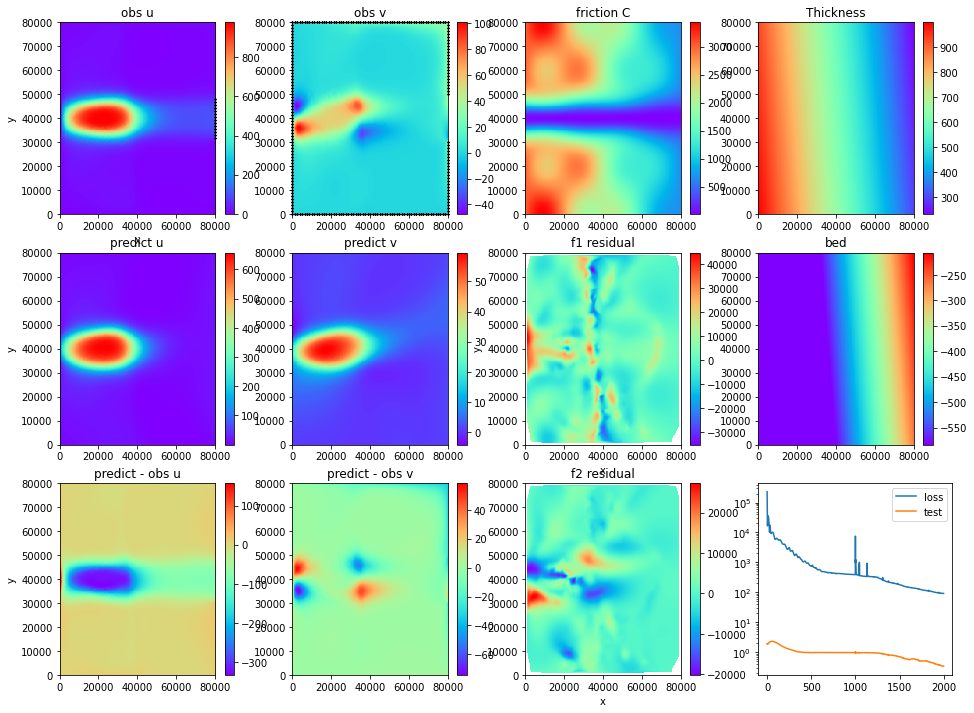

In [6]:
# plot
#plot_Helheim(pinn, X_f, X_u_train, u_train, xlb, xub)
plot_Helheim(pinn, X_f, X_star, u_star, xlb, xub)

# fit the data
#pinn.fit(X_u_train, u_train)
#u_pred, v_pred = pinn.predict(X_star)

# test
#plot_H_bed(pinn, X_star, u_star, xlb, xub)

In [7]:
tf.shape_n(pinn.model.trainable_variables)

[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 2, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([20], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([20], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([20], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([20], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([20], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([20], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=int32, numpy=array([20, 20], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array

In [8]:
def _get_indices(trainable_vars):
    # we'll use tf.dynamic_stitch and tf.dynamic_partition,
    # so we need to prepare required information
    shapes = tf.shape_n(trainable_vars)
    count = 0
    stitch_indices = []
    partition_indices = []
    for i, shape in enumerate(shapes):
        n = np.product(shape.numpy())
        stitch_indices.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
        partition_indices.extend([i] * n)
        count += n
    partition_indices = tf.constant(partition_indices)
    return partition_indices, stitch_indices

In [9]:
a,b =_get_indices(pinn.model.trainable_variables)

In [10]:
a

<tf.Tensor: shape=(3042,), dtype=int32, numpy=array([ 0,  0,  0, ..., 16, 17, 17], dtype=int32)>